In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from latent_geometry.model.mnist_vae import load_decoder
from latent_geometry.optim.torch import InputSGDOptimizer
from latent_geometry.optim.metric import TorchMetric
from torch.optim import SGD
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import os
from typing import Callable

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
DEVICE = "cuda"

In [5]:
decoder = load_decoder(DEVICE, "beta_10_decoder.pt")
decoder

DecoderVAE(
  (fcs): Sequential(
    (fc): Linear(in_features=2, out_features=64, bias=True)
    (tanh): Tanh()
  )
  (deconvs): Sequential(
    (deconv1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
    (tanh1): Tanh()
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (tanh2): Tanh()
    (deconv3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (tanh3): Tanh()
    (deconv4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [6]:
def imshow(z: torch.tensor):
    plt.imshow(decoder.decode(z.to(DEVICE)).cpu().detach().reshape(32, 32))
    plt.show()

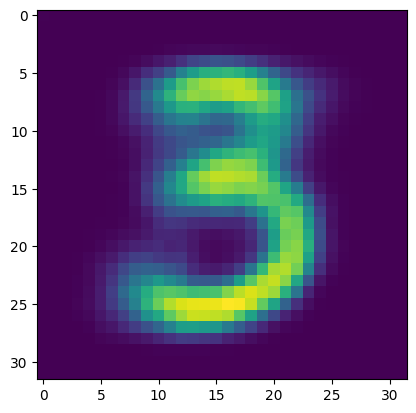

In [7]:
z = torch.tensor([[0, 0]], dtype=torch.float32, requires_grad=True)
imshow(z)

In [8]:
def run(z: torch.Tensor, iters: int, optimizer, show_img: bool = False) -> torch.Tensor:
    path = []
    for iter in range(iters):
        optimizer.zero_grad()
        loss = -decoder.decode(z).mean()

        # optimizer
        loss.backward()
        if iter % (iters // 3) == 0:
            print(f"{iter=}, {z=}, {z.grad=}, {loss.item()=:.4f}")
            if show_img:
                imshow(z)
        path.append(z.unsqueeze(0).clone())
        optimizer.step()
    return torch.concat(path)

In [9]:
metric = TorchMetric(mapping=decoder.decode)

In [10]:
Z = torch.tensor([[1, 0]], dtype=torch.float32, requires_grad=True).to(DEVICE)

In [11]:
metric._metric_matrix(Z)

tensor([[22.5544, 17.4716],
        [17.4716, 69.9813]], device='cuda:0')

In [12]:
metric._cometric_matrix(Z)

tensor([[ 0.0550, -0.0137],
        [-0.0137,  0.0177]], device='cuda:0')

In [13]:
def summarize_path(
    path: torch.Tensor,
    metric: TorchMetric,
    loss_fn: Callable[[torch.Tensor], torch.Tensor],
) -> pd.DataFrame:
    data = []
    x_len, z_euc_len, z_man_len = 0.0, 0.0, 0.0
    for i, (z, z_next) in enumerate(zip(path[:-1], path[1:])):
        x, x_next = metric.mapping(z), metric.mapping(z_next)
        loss, loss_next = loss_fn(x).item(), loss_fn(x_next).item()
        dz = z_next - z
        dx = x_next - x
        dx_len = metric.euclidean_length(dx, x).item()
        x_len += dx_len
        dz_man_len = metric.manifold_length(dz, z).item()
        z_man_len += dz_man_len
        dz_euc_len = metric.euclidean_length(dz, z).item()  # ?
        z_euc_len += dz_euc_len

        data.append(
            [
                i,
                x_len,
                z_man_len,
                z_euc_len,
                loss,
                loss_next - loss,
                z[0, 0].item(),
                z[0, 1].item(),
                dx_len,
                dz_man_len,
                dz_euc_len,
            ]
        )
    df = pd.DataFrame(
        columns=[
            "iter",
            "x_len",
            "z_man_len",
            "z_euc_len",
            "loss",
            "dloss",
            "z0",
            "z1",
            "dx_len",
            "dz_man_len",
            "dz_euc_len",
        ],
        data=data,
    )
    df["gamma"] = df.x_len
    return df

In [23]:
paths = []
dfs = []
SETUP = [("standard", 0.005), ("geometric", 0.7), ("retractive", 0.05)]
for gt, lr in SETUP:
    z = Z.clone().detach().requires_grad_()
    optimizer = InputSGDOptimizer(
        z,
        metric=metric,
        lr=lr,
        gradient_type=gt,
    )
    path = run(z, 1001, optimizer, show_img=False)
    paths.append(path)
    df = summarize_path(path, metric, lambda x: -torch.mean(x))
    df["method"] = gt
    dfs.append(df)

df = pd.concat(dfs)

iter=0, z=tensor([[1., 0.]], device='cuda:0', requires_grad=True), z.grad=tensor([[0.0320, 0.0690]], device='cuda:0'), loss.item()=-0.1204
iter=333, z=tensor([[ 0.9427, -0.1106]], device='cuda:0', requires_grad=True), z.grad=tensor([[0.0402, 0.0713]], device='cuda:0'), loss.item()=-0.1298
iter=666, z=tensor([[ 0.8821, -0.2176]], device='cuda:0', requires_grad=True), z.grad=tensor([[0.0409, 0.0527]], device='cuda:0'), loss.item()=-0.1389
iter=999, z=tensor([[ 0.7882, -0.2725]], device='cuda:0', requires_grad=True), z.grad=tensor([[0.1053, 0.0242]], device='cuda:0'), loss.item()=-0.1467
iter=0, z=tensor([[1., 0.]], device='cuda:0', requires_grad=True), z.grad=tensor([[0.0320, 0.0690]], device='cuda:0'), loss.item()=-0.1204
iter=333, z=tensor([[ 0.8253, -0.1942]], device='cuda:0', requires_grad=True), z.grad=tensor([[0.0534, 0.0641]], device='cuda:0'), loss.item()=-0.1404
iter=666, z=tensor([[ 0.7568, -0.3439]], device='cuda:0', requires_grad=True), z.grad=tensor([[ 0.1183, -0.0071]], dev

In [15]:
df.head(1)

,iter,x_len,z_man_len,z_euc_len,loss,dloss,z0,z1,dx_len,dz_man_len,dz_euc_len,gamma,method
0,0,0.00329,0.003292,0.00038,-0.120427,-0.000029,1.0,0.0,0.00329,0.003292,0.00038,0.00329,standard


<Axes: xlabel='gamma', ylabel='loss'>

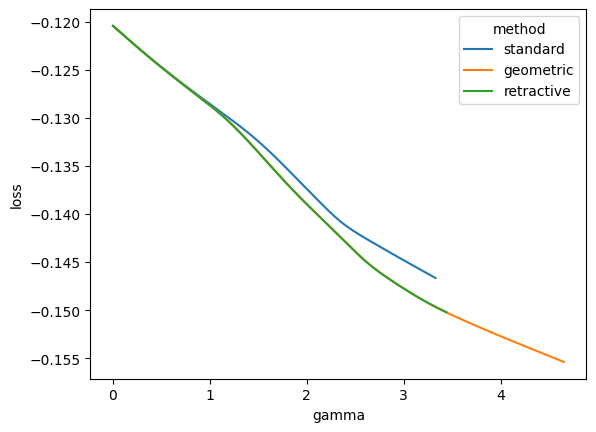

In [16]:
sns.lineplot(df, x="gamma", y="loss", hue="method")

<Axes: xlabel='iter', ylabel='loss'>

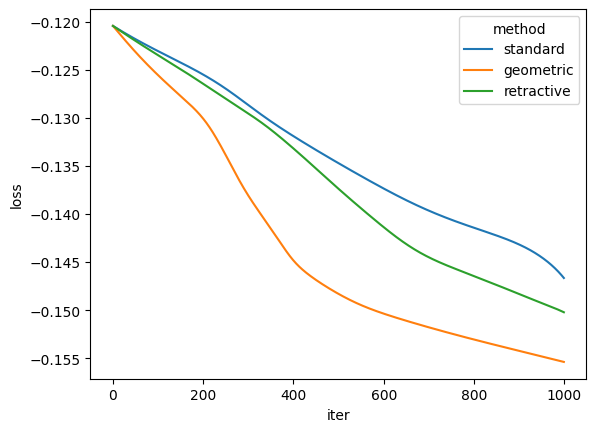

In [17]:
sns.lineplot(df, x="iter", y="loss", hue="method")

<Axes: xlabel='z0', ylabel='z1'>

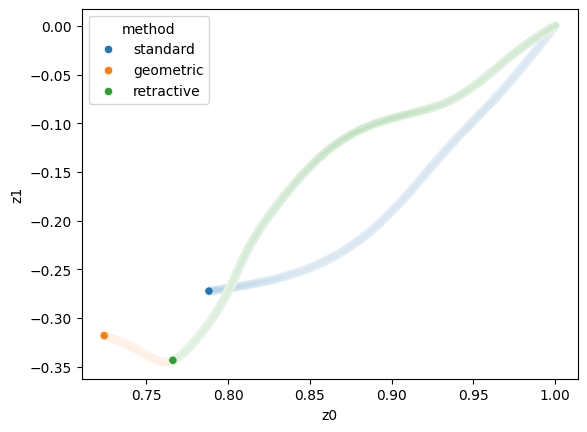

In [18]:
sns.scatterplot(
    df,
    x="z0",
    y="z1",
    hue="method",
)

In [19]:
df.head(1)

,iter,x_len,z_man_len,z_euc_len,loss,dloss,z0,z1,dx_len,dz_man_len,dz_euc_len,gamma,method
0,0,0.00329,0.003292,0.00038,-0.120427,-0.000029,1.0,0.0,0.00329,0.003292,0.00038,0.00329,standard


<Axes: xlabel='gamma', ylabel='dz_euc_len'>

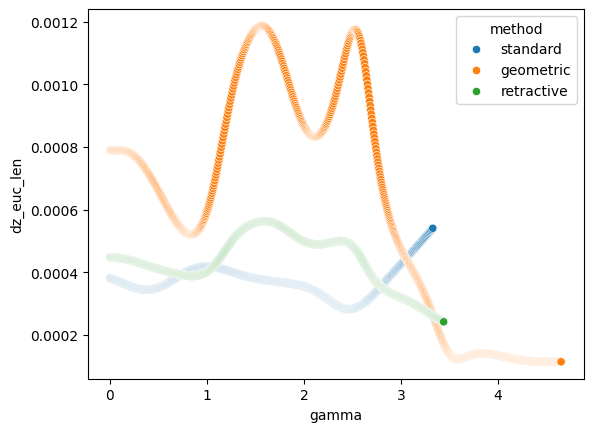

In [20]:
sns.scatterplot(df, x="gamma", y="dz_euc_len", hue="method")

<Axes: xlabel='iter', ylabel='gamma'>

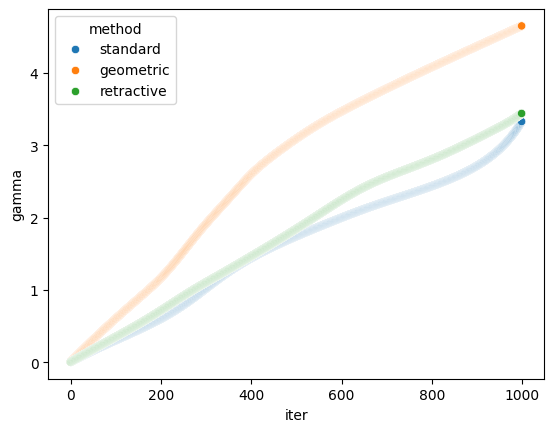

In [21]:
sns.scatterplot(df, x="iter", y="gamma", hue="method")

<Axes: xlabel='gamma', ylabel='dloss'>

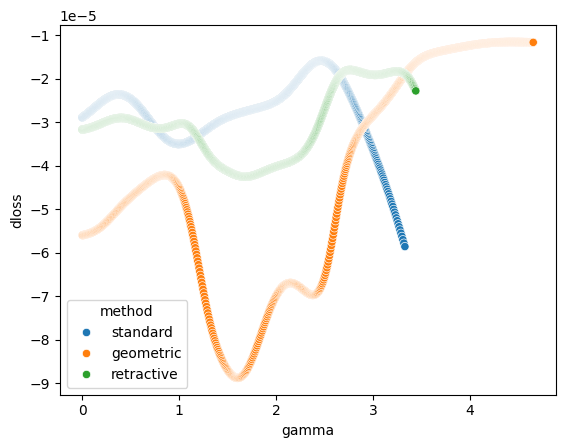

In [22]:
sns.scatterplot(df, x="gamma", y="dloss", hue="method")